In [516]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [235]:
def adjust(val, length= 6): return str(val).ljust(length)

In [2]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [98]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

def TooDifferent(item1,item2):
    print(df[item1].sum(),'',df[item2].sum())
    return (df[item1].sum()/10 >  df[item2].sum() or  df[item2].sum()/10 >  df[item1].sum())

In [102]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def verifyErrors(forecast,actual,colunas):        
    for i in colunas:
        print(i)
        itemI = i.replace('_forecast','')
        print(f'Forecast Accuracy of: {itemI}')
        accuracy_prod = forecast_accuracy(df_results[i].values, dfVAR2_test[itemI])
        for k, v in accuracy_prod.items():
            print(adjust(k), ': ', round(v,4))
        print('\n')

In [84]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [85]:
dfOutli = []
df = df_count_day_typeGRP.resample('QS').sum().copy()
df = df['2012-01-01':]
valor = df['total'].sum()# - 1619483 - 1366115 - 813246
for i in df.columns:    
    dfOutli.append({'nome':i,'Qtd':df[i].sum(),'Percent':round((df[i].sum()*100)/valor,2),'QtdDiasZero':df[df[i]==0][[i]].count().item(),'QtdNaoZero':df[df[i]!=0][[i]].count().item()})

    
#PEGAR SO AQUELES QUE TEM QUANTIDADE SENAO NAO ADIANTA FAZER VAR
    
dfValidTypes = pd.DataFrame(dfOutli).sort_values(by='Percent',ascending=False)
# ver apenas aqueles que tem dados em pelo menos 50% ou mais dos quartis
#display(dfValidTypes[dfValidTypes['QtdNaoZero']>12])

dfListOfTypes = np.array(dfValidTypes[dfValidTypes['QtdNaoZero']>12]['nome'])
dfListOfTypes = np.append(dfListOfTypes,'weekDay')
dfListOfTypes = np.append(dfListOfTypes,'weekType')
dfListOfTypes = np.append(dfListOfTypes,'Feriado')
dfListOfTypes

array(['total', 'Apelação Cível', 'Agravo de Instrumento',
       'Embargos de Declaração', 'Recurso Cível', 'Agravo',
       'Apelação Crime', 'Habeas Corpus', 'Apelação e Reexame Necessário',
       'Reexame Necessário', 'Recurso Crime', 'Conflito de Competência',
       'Recurso em Sentido Estrito', 'Agravo Regimental',
       'Mandado de Segurança', 'Embargos Infringentes e de Nulidade',
       'weekDay', 'Embargos Infringentes', 'Ação Rescisória',
       'Revisão Criminal', 'Correição Parcial', 'Conflito de Jurisdição',
       'Feriado', 'Mandado de Injunção', 'Agravo Interno', 'weekType',
       'Ação Direta de Inconstitucionalidade', 'Petição',
       'Exceção de Suspeição', 'Mandado de Segurança Crime',
       'Incidente de Uniformizacao Jurisprudencia', 'Carta Testemunhável',
       'Representação Criminal', 'Recurso de Ofício',
       'Cautelar Inominada', 'Ação Penal',
       'Uniformização de Jurisprudência', 'Termo Circunstanciado',
       'Restauração de Autos', 'Medida C

In [242]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP

#USAR SOMENTE SERIES QUE NAO CONTENHAM POUCOS REGISTROS 
df = df[dfListOfTypes]
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()
dfAllPeriod = df.resample('30A').sum()
figsize=(12,8)
field = 'total'
VARFields = dfListOfTypes[1:10]
testPercentSize=20
predictFieldPeriod=12
sazonalPeriod = 12 

In [273]:
dfChoosed = dfMonth.copy()
dfDiff = dfMonth.copy()

while(adf_teste(dfDiff[field],'',False)[0] >0.05):    
    dfDiff[field] = diff(dfDiff[field],k_diff=1)
    dfDiff = dfDiff.dropna()

In [274]:
test_size = (len(dfDiff) - int((testPercentSize * len(dfDiff))/100))
trainDiff = dfDiff.iloc[:test_size]
testDiff = dfDiff.iloc[test_size:]    


test_size = (len(dfChoosed) - int((testPercentSize * len(dfChoosed))/100))
train = dfChoosed.iloc[:test_size]
test = dfChoosed.iloc[test_size:]   

In [275]:
print(len(trainDiff),len(testDiff))
print(len(train),len(test))

display(trainDiff.head())
display(train.head())

172 43
173 43


,total,Apelação Cível,Agravo de Instrumento,Embargos de Declaração,Recurso Cível,Agravo,Apelação Crime,Habeas Corpus,Apelação e Reexame Necessário,Reexame Necessário,...,Medida Cautelar,Desaforamento,Crimes contra a honra,Incidente de Inconstitucionalidade,Impugnação à Assistência Judiciária,Impugnação ao Valor da Causa,Inquérito Policial,weekDay,weekType,Feriado
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-02-01,212.0,151,35,2,0,4,1,0,25,1,...,0,0,0,0,0,0,0,85,21,29
2000-03-01,351.0,277,93,30,0,17,5,0,118,21,...,0,0,0,0,0,0,0,93,23,31
2000-04-01,74.0,343,145,19,0,18,3,2,89,14,...,0,0,0,0,0,0,0,95,20,29
2000-05-01,449.0,595,318,78,0,11,7,3,53,16,...,1,0,0,0,0,1,0,87,23,30
2000-06-01,1209.0,1170,410,362,0,58,45,26,156,16,...,0,0,0,0,0,0,0,91,22,30


,total,Apelação Cível,Agravo de Instrumento,Embargos de Declaração,Recurso Cível,Agravo,Apelação Crime,Habeas Corpus,Apelação e Reexame Necessário,Reexame Necessário,...,Medida Cautelar,Desaforamento,Crimes contra a honra,Incidente de Inconstitucionalidade,Impugnação à Assistência Judiciária,Impugnação ao Valor da Causa,Inquérito Policial,weekDay,weekType,Feriado
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-01-01,10,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,84,21,29
2000-02-01,222,151,35,2,0,4,1,0,25,1,...,0,0,0,0,0,0,0,85,21,29
2000-03-01,573,277,93,30,0,17,5,0,118,21,...,0,0,0,0,0,0,0,93,23,31
2000-04-01,647,343,145,19,0,18,3,2,89,14,...,0,0,0,0,0,0,0,95,20,29
2000-05-01,1096,595,318,78,0,11,7,3,53,16,...,1,0,0,0,0,1,0,87,23,30


# Simple Exponential Smoothing

### Exponential Smoothing ocorre sobre dados não estácionarios

In [276]:
dfSimpleExpSmooth = dfChoosed.dropna()
dfSimpleExpSmooth = dfSimpleExpSmooth[[field]]

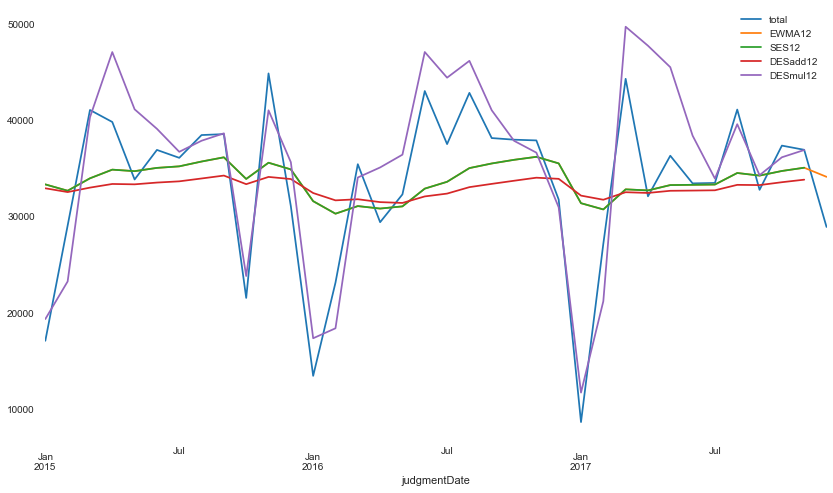

In [277]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


span = predictFieldPeriod
alpha = 2/(span+1)

SimpleExpSmoothFields = [field]


dfSimpleExpSmooth['EWMA'+str(predictFieldPeriod)] = dfSimpleExpSmooth[field].ewm(alpha=alpha,adjust=False).mean()
dfSimpleExpSmooth['SES'+str(predictFieldPeriod)]= SimpleExpSmoothing(dfSimpleExpSmooth[field]).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

dfSimpleExpSmooth['DESadd'+str(predictFieldPeriod)] = ExponentialSmoothing(dfSimpleExpSmooth[field], trend='add').fit().fittedvalues.shift(-1)
try:
    dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)] = ExponentialSmoothing(dfSimpleExpSmooth[field], trend='mul').fit().fittedvalues.shift(-1)
except:
    print('erro mul')
    
dfSimpleExpSmooth.tail(36).plot(figsize=(14,8)).autoscale(axis='x',tight=True);

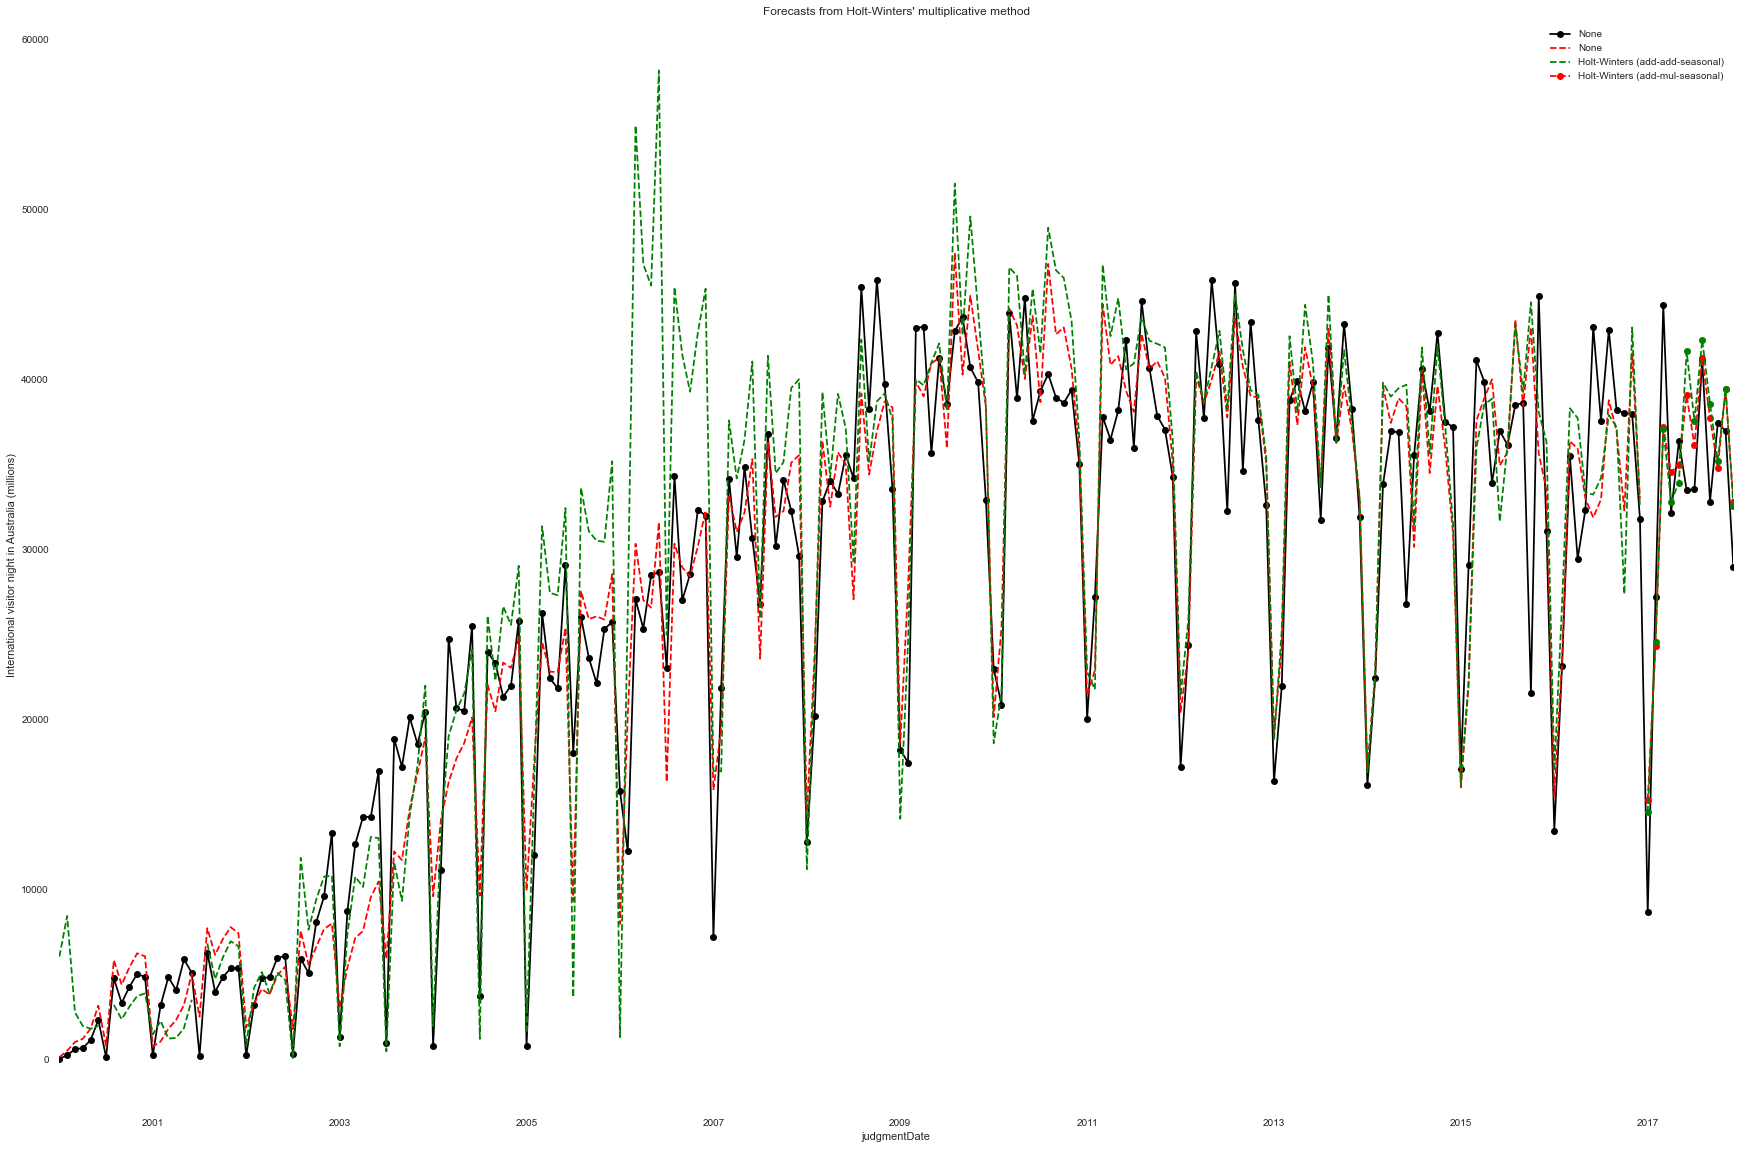

Exponential Smoothing (additional):  6716.590273332058
Exponential Smoothing (multiplicate)  7365.420027868237


In [278]:
dfSimpleExpSmoothTest = dfSimpleExpSmooth.copy()
dfSimpleExpSmoothTest=dfSimpleExpSmoothTest['2000-01-01':'2016-12-31']

fit1 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = dfSimpleExpSmooth[field].plot(figsize=(30,20), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red',legend=True)
fit2.fittedvalues.plot(ax=ax, style='--', color='green',legend=True)
#
fit1.forecast(predictFieldPeriod).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(predictFieldPeriod).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
#
plt.show()
#print("Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.")
#
results

HwForeCastAdd = fit1.forecast(predictFieldPeriod).rename('Holt-Winters (add-add-seasonal)')
HwForeCastMul = fit2.forecast(predictFieldPeriod).rename('Holt-Winters (add-mul-seasonal)')

display()

print("Exponential Smoothing (additional): ",forecast_accuracy(dfSimpleExpSmooth['DESmul12'][-predictFieldPeriod:],HwForeCastAdd)['rmse'])
print("Exponential Smoothing (multiplicate) ",forecast_accuracy(dfSimpleExpSmooth['DESmul12'][-predictFieldPeriod:],HwForeCastMul)['rmse'])

# Autoregressive Model

In [287]:
dfChoosedAR = dfChoosed.copy()
dfDiffAR = dfDiff.copy()

AR(1) : 11018.575977425984
AR(2) : 10181.79148359231
AR(14) : 6184.545540141704


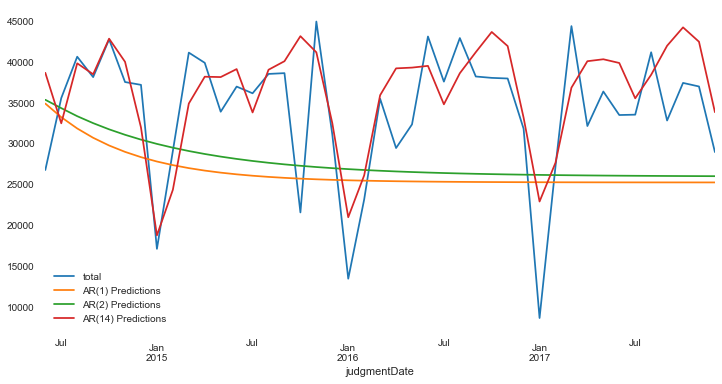

In [298]:
from statsmodels.tsa.ar_model import AR,ARResults

arTrain=train 
arTest=test


modelArima = AR(arTrain[field])
AR1fit = modelArima.fit(maxlag=1,method='cmle')
#print(f'Lag: {AR1fit.k_ar}')
#print(f'Coefficients:\n{AR1fit.params}')

start=len(arTrain)
end=len(arTrain)+len(arTest)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

modelArima2 = AR(arTrain[field])
AR2fit = modelArima2.fit(maxlag=2,method='cmle')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

modelArima3 = AR(arTrain[field])

AR3fit = modelArima3.fit(method='cmle')
#print(f'Lag: {AR3fit.k_ar}')
#print(f'Coefficients:\n{AR3fit.params}')
rename = f'AR({AR3fit.k_ar}) Predictions'

predictions11 = AR3fit.predict(start=start,end=end,dynamic=False).rename( f'AR({AR3fit.k_ar}) Predictions')

arTest[field].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

from sklearn.metrics import mean_squared_error
labelsAR = ['AR(1)','AR(2)',f'AR({AR3fit.k_ar})']
ArimaPreds = [predictions1, predictions2, predictions11]  # these are variables, not strings!
ArimaPredsResult = []

for i in range(3):
    print(labelsAR[i],':',forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])
    ArimaPredsResult.append(forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])
    #error = mean_squared_error(test[field], preds[i])
    #print(f'{labels[i]} Error: {error:11.10}')


# CMLE foi melhor do que MLE

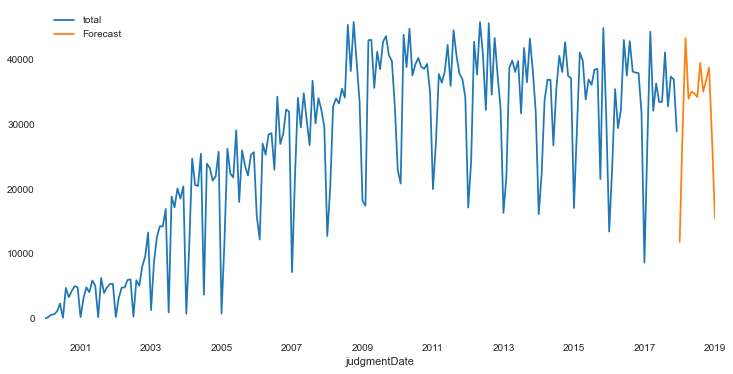

In [300]:
modelARForecast = AR(dfChoosedAR[field])
ARfitForecast = modelARForecast.fit(maxlag=AR3fit.k_ar,method='cmle')
# Make predictions
fcastAR = ARfitForecast.predict(start=len(dfChoosedAR), end=len(dfChoosedAR)+predictFieldPeriod, dynamic=False).rename('Forecast')
dfChoosedAR[field].plot(legend=True)
fcastAR.plot(legend=True,figsize=(12,6));

# Tests for Stationarity

A time series is stationary if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is not stationary.

A test for stationarity usually involves a unit root hypothesis test, where the null hypothesis  𝐻0  is that the series is nonstationary, and contains a unit root. The alternate hypothesis  𝐻1  supports stationarity. The augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests are stationarity tests.

## Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

In [319]:
#adf_teste(dfChoosed[field])
print(adf_teste(dfChoosed[field]))
print(adf_teste(dfDiff[field]))

(0.10219011015738777, '', -2.5571079596619577, 14, 201, {'1%': -3.4633090972761744, '5%': -2.876029332045744, '10%': -2.5744932593252643}, 3953.4211936388106, 'Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary')
(0.005359290063266703, '', -3.6217099251587053, 15, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 3939.1954624144064, 'Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary')


## TESTANDO SAZONALIDADE COM GRAFICO

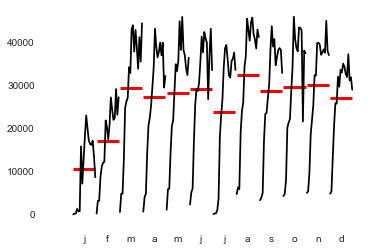

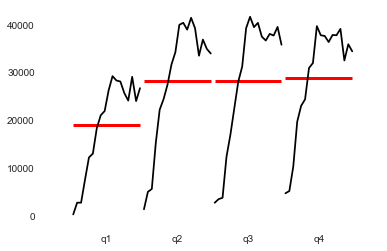

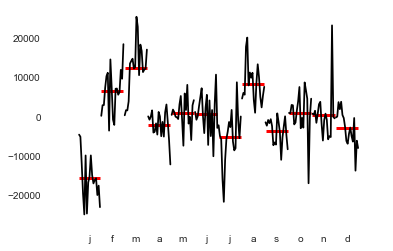

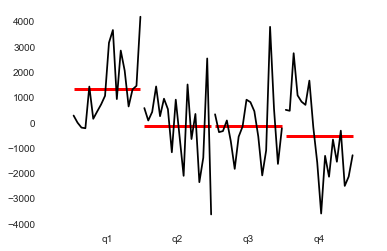

In [320]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
month_plot(dfChoosed[field]);

dfq = dfChoosed[field].resample(rule='Q').mean()
quarter_plot(dfq);
month_plot(dfDiff[field]);
dfq = dfDiff[field].resample(rule='Q').mean()
quarter_plot(dfq);

# ARMA

# EXEMPLO ARMA SEM INDICAR SAZONALIDADE 

In [430]:
auto_arima(trainDiff[field],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  172
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -1761.569
Date:                Sat, 16 May 2020   AIC                           3535.138
Time:                        23:54:09   BIC                           3554.023
Sample:                             0   HQIC                          3542.800
                                - 172                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    328.1127    223.097      1.471      0.141    -109.150     765.375
ar.L1         -0.9993      0.004   -223.472      0.000      -1.008      -0.991
ma.L1          0.4950      0.099      4.987      0.000       0.300       0.690
ma.L2         -0.8607      0.068    -12.618      0.000      -0.994      -0.727
ma.L3         -0.3664      0.106     -3.456      0.001      -0.574      -0.159
sigma2      5.395e+07      0.001   7.16e+10      0.000    5.39e+07    5.39e+07
===================================================================================
Ljung-Box (Q):                      313.93   Jarque-Bera (JB):                22.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.72
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+27. Standard errors may be unstable.
"""

In [432]:
ARIMAauto_arimaNoSeasonal = auto_arima(trainDiff[field],seasonal=True,stationary=True)
ARIMAauto_arimaNoSeasonal

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [434]:
modelARMANoSeasonal = SARIMAX(trainDiff[field],order=ARIMAauto_arimaNoSeasonal.order,seasonal_order=ARIMAauto_arimaNoSeasonal.seasonal_order)
resultARMANoSeasonal = modelARMANoSeasonal.fit()
resultARMANoSeasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  total   No. Observations:                  172
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -1764.662
Date:                Sat, 16 May 2020   AIC                           3539.324
Time:                        23:55:29   BIC                           3555.062
Sample:                    02-01-2000   HQIC                          3545.709
                         - 05-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9904      0.021    -48.171      0.000      -1.031      -0.950
ma.L1          0.5275      0.111      4.768      0.000       0.311       0.744
ma.L2         -0.7983      0.073    -10.901      0.000      -0.942      -0.655
ma.L3         -0.3716      0.093     -3.990      0.000      -0.554      -0.189
sigma2      5.709e+07   5.98e-10   9.54e+16      0.000    5.71e+07    5.71e+07
===================================================================================
Ljung-Box (Q):                      322.48   Jarque-Bera (JB):                24.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.70
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.35e+32. Standard errors may be unstable.
"""

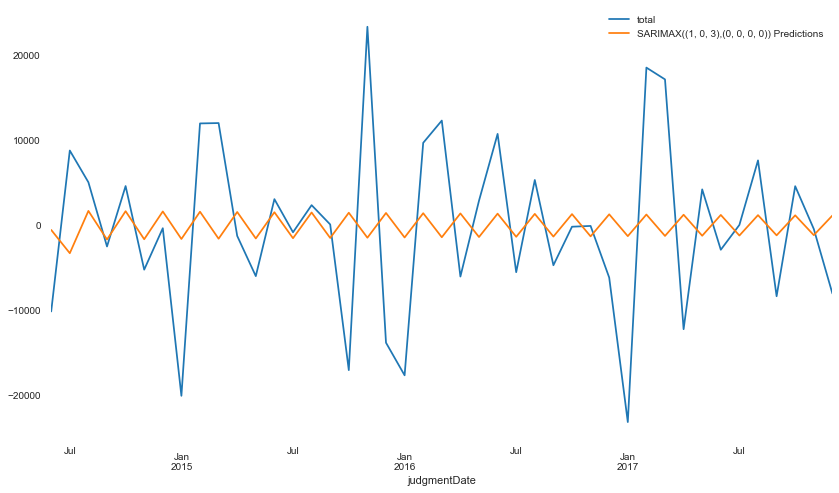

SARIMAX:                                 10182.269626958234


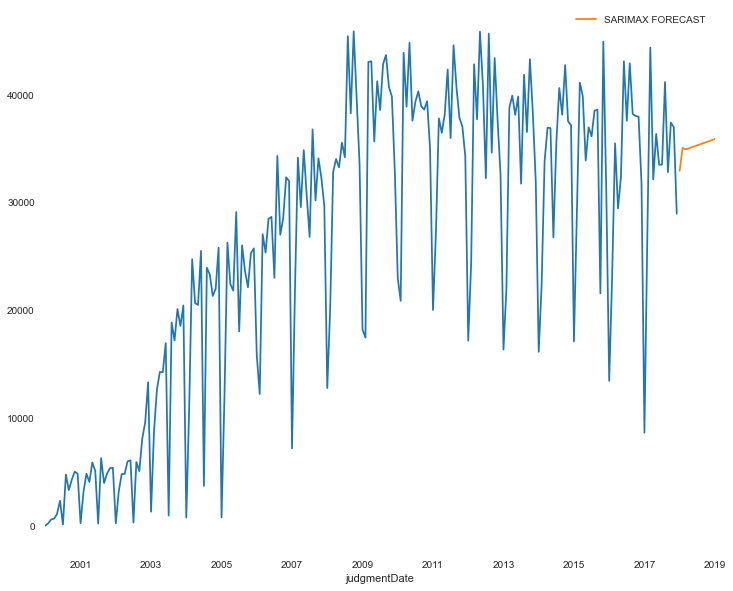

In [435]:
start=len(trainDiff)
end=len(trainDiff)+len(testDiff)-1

predictionsARMANoSeasonal = resultARMANoSeasonal.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arimaNoSeasonal.order},{ARIMAauto_arimaNoSeasonal.seasonal_order}) Predictions')
ax = testDiff[field].plot(legend=True,figsize=(14,8))
predictionsARMANoSeasonal.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(adjust('SARIMAX: ',40),forecast_accuracy(testDiff[field], predictionsARMANoSeasonal)['rmse'])


modelARIMANoSeasonal = SARIMAX(dfChoosed[field],order=ARIMAauto_arimaNoSeasonal.order,seasonal_order=ARIMAauto_arimaNoSeasonal.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMANoSeasonal = modelARIMANoSeasonal.fit()
fcastARIMANoSeasonal = resultsForeCastARIMANoSeasonal.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMANoSeasonal.rename('SARIMAX FORECAST').plot(legend=True)

### Teoria: ARMA

In [438]:
auto_arima(trainDiff[field],seasonal=True,m=predictFieldPeriod).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  172
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1676.704
Date:                                 Sat, 16 May 2020   AIC                           3369.408
Time:                                         23:59:57   BIC                           3394.588
Sample:                                              0   HQIC                          3379.624
                                                 - 172                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -41.8257     14.692     -2.847      0.004     -70.622     -13.029
ar.L1         -0.6925      0.060    -11.607      0.000      -0.809      -0.576
ar.L2         -0.3046      0.039     -7.859      0.000      -0.381      -0.229
ar.S.L12      -0.0565      0.026     -2.136      0.033      -0.108      -0.005
ar.S.L24       0.9435      0.053     17.902      0.000       0.840       1.047
ma.S.L12       0.6320      0.058     10.825      0.000       0.518       0.746
ma.S.L24      -0.3680      0.083     -4.443      0.000      -0.530      -0.206
sigma2      1.349e+07    8.7e-05   1.55e+11      0.000    1.35e+07    1.35e+07
===================================================================================
Ljung-Box (Q):                       58.39   Jarque-Bera (JB):                 5.00
Prob(Q):                              0.03   Prob(JB):                         0.08
Heteroskedasticity (H):               0.99   Skew:                            -0.22
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.15e+27. Standard errors may be unstable.
"""

<hr>
<h1 style="color:red"> VERIFICAR RETORNO DO MODELO </h1>
<hr>

## RETORNOU PARA USO SARIMAX

In [439]:
ARIMAauto_arima = auto_arima(trainDiff[field],seasonal=True,stationary=True,m=12)
ARIMAauto_arima

ARIMA(maxiter=50, method='lbfgs', order=(2, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [440]:
modelARMA = SARIMAX(trainDiff[field],order=ARIMAauto_arima.order,seasonal_order=ARIMAauto_arima.seasonal_order)
resultARMA = modelARMA.fit()
resultARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   total   No. Observations:                  172
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1675.617
Date:                                 Sun, 17 May 2020   AIC                           3365.235
Time:                                         00:00:27   BIC                           3387.267
Sample:                                     02-01-2000   HQIC                          3374.174
                                          - 05-01-2014                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6959      0.070     -9.945      0.000      -0.833      -0.559
ar.L2         -0.3064      0.075     -4.100      0.000      -0.453      -0.160
ar.S.L12       1.9447      0.059     32.919      0.000       1.829       2.061
ar.S.L24      -0.9470      0.050    -19.044      0.000      -1.044      -0.850
ma.S.L12      -1.3998      0.157     -8.925      0.000      -1.707      -1.092
ma.S.L24       0.4037      0.084      4.781      0.000       0.238       0.569
sigma2      1.511e+07   1.96e-08   7.71e+14      0.000    1.51e+07    1.51e+07
===================================================================================
Ljung-Box (Q):                       59.25   Jarque-Bera (JB):                 4.70
Prob(Q):                              0.03   Prob(JB):                         0.10
Heteroskedasticity (H):               0.98   Skew:                            -0.22
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.42e+29. Standard errors may be unstable.
"""

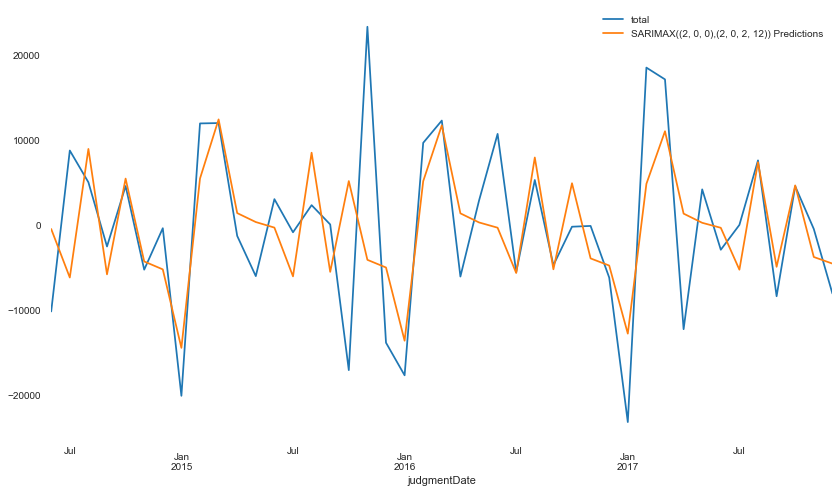

SARIMAX:                                 8067.010684513909


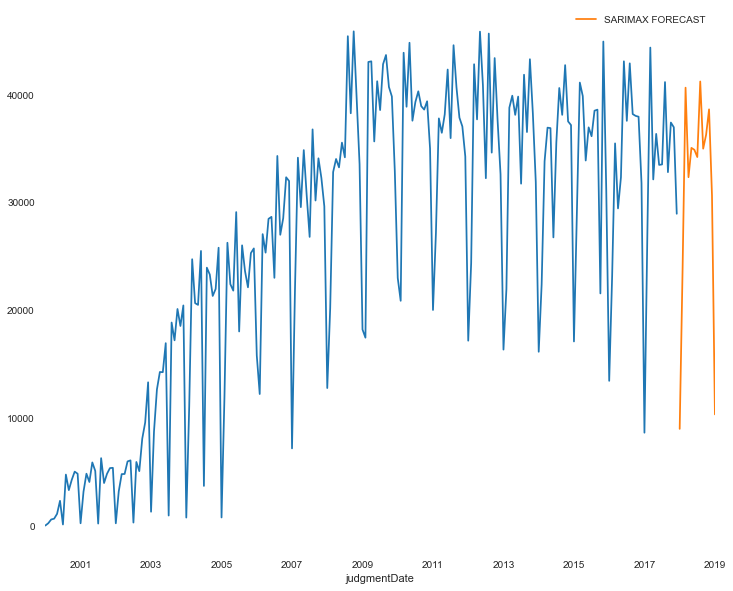

In [441]:
start=len(trainDiff)
end=len(trainDiff)+len(testDiff)-1

predictionsARMA = resultARMA.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arima.order},{ARIMAauto_arima.seasonal_order}) Predictions')
ax = testDiff[field].plot(legend=True,figsize=(14,8))
predictionsARMA.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(adjust('SARIMAX: ',40),forecast_accuracy(testDiff[field], predictionsARMA)['rmse'])


modelARIMA = SARIMAX(dfChoosed[field],order=ARIMAauto_arima.order,seasonal_order=ARIMAauto_arima.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMA = modelARIMA.fit()
fcastARIMA = resultsForeCastARIMA.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMA.rename('SARIMAX FORECAST').plot(legend=True)


# APLICANDO EXOGENOUS DATA 

### Teoria: ARMA

In [478]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data = trainDiff.copy()
#display(data.head(2))

# Dados sao estacionarios devido ao diff ja feito, portanto modelo deve ser add 
result_mul = seasonal_decompose(data[field][-36:],model='add',extrapolate_trend='freq') 

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
seasonal_index.head(2)

#merge with the base data
data['month'] = data.index.month
dfSeasonalDiff = pd.merge(data, seasonal_index, how='left', on='month')
dfSeasonalDiff.index = data.index  # reassign the index.
display(dfSeasonalDiff.head(2))



#display(df.head(20))

,total,Apelação Cível,Agravo de Instrumento,Embargos de Declaração,Recurso Cível,Agravo,Apelação Crime,Habeas Corpus,Apelação e Reexame Necessário,Reexame Necessário,...,Crimes contra a honra,Incidente de Inconstitucionalidade,Impugnação à Assistência Judiciária,Impugnação ao Valor da Causa,Inquérito Policial,weekDay,weekType,Feriado,month,seasonal
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-02-01,212.0,151,35,2,0,4,1,0,25,1,...,0,0,0,0,0,85,21,29,2,6455.244015
2000-03-01,351.0,277,93,30,0,17,5,0,118,21,...,0,0,0,0,0,93,23,31,3,15650.599590


In [483]:
auto_arima(dfSeasonalDiff[[field]],seasonal=True,m=predictFieldPeriod,exogenous=dfSeasonalDiff[['seasonal']]).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  172
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 12)   Log Likelihood               -1653.107
Date:                             Sun, 17 May 2020   AIC                           3318.214
Time:                                     00:35:50   BIC                           3337.099
Sample:                                 02-01-2000   HQIC                          3325.876
                                      - 05-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     73.5963     54.072      1.361      0.173     -32.383     179.576
seasonal       0.6875      0.049     13.976      0.000       0.591       0.784
ma.L1         -0.7948      0.075    -10.589      0.000      -0.942      -0.648
ma.L2         -0.0133      0.071     -0.186      0.853      -0.153       0.127
ar.S.L12       0.5362      0.059      9.055      0.000       0.420       0.652
sigma2      1.268e+07      0.000   1.24e+11      0.000    1.27e+07    1.27e+07
===================================================================================
Ljung-Box (Q):                       31.73   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.82   Prob(JB):                         0.81
Heteroskedasticity (H):               0.77   Skew:                            -0.09
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.14e+27. Standard errors may be unstable.
"""

<hr>
<h1 style="color:red"> VERIFICAR RETORNO DO MODELO </h1>
<hr>

## RETORNOU PARA USO SARIMAX

In [486]:
ARIMAauto_arimaExog = auto_arima(dfSeasonalDiff[[field]],seasonal=True,stationary=True,m=12,exogenous=dfSeasonalDiff[['seasonal']])
ARIMAauto_arimaExog

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [487]:
modelARMAExog = SARIMAX(trainDiff[field],order=ARIMAauto_arimaExog.order,seasonal_order=ARIMAauto_arimaExog.seasonal_order)
resultARMAExog = modelARMAExog.fit()
resultARMAExog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  172
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 12)   Log Likelihood               -1671.894
Date:                             Sun, 17 May 2020   AIC                           3351.787
Time:                                     00:37:38   BIC                           3364.377
Sample:                                 02-01-2000   HQIC                          3356.895
                                      - 05-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8503      0.069    -12.276      0.000      -0.986      -0.715
ma.L2          0.0218      0.066      0.329      0.742      -0.108       0.151
ar.S.L12       0.8357      0.034     24.368      0.000       0.768       0.903
sigma2      1.485e+07   5.86e-10   2.53e+16      0.000    1.48e+07    1.48e+07
===================================================================================
Ljung-Box (Q):                       41.51   Jarque-Bera (JB):                 6.47
Prob(Q):                              0.40   Prob(JB):                         0.04
Heteroskedasticity (H):               1.27   Skew:                            -0.16
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

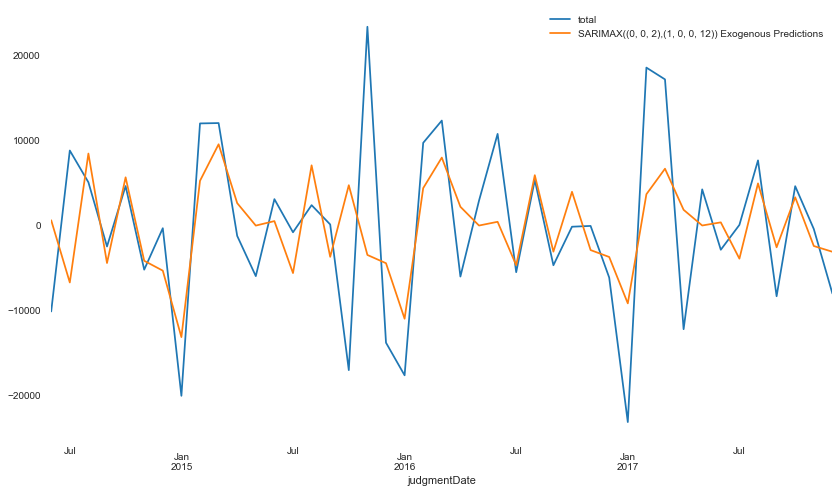

SARIMAX:                                 8416.83357249019


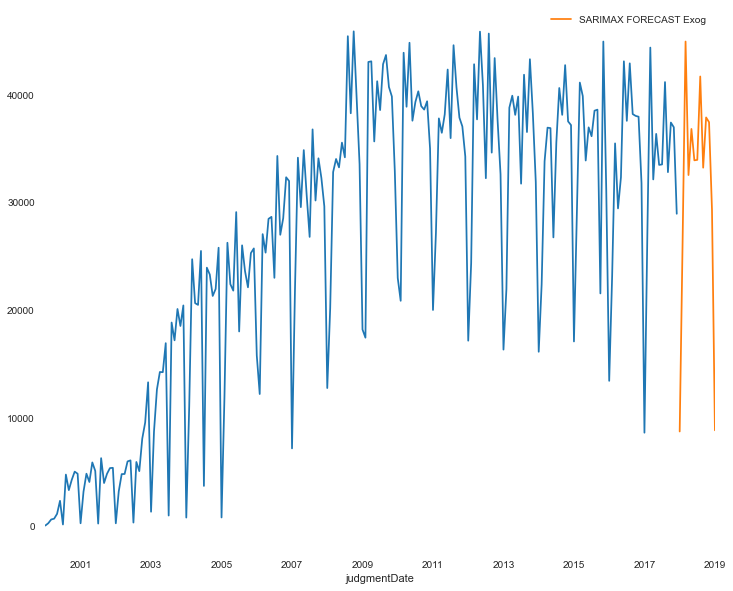

In [496]:
start=len(trainDiff)
end=len(trainDiff)+len(testDiff)-1

predictionsARMAExog = resultARMAExog.predict(start=start, end=end,exogenous=np.tile(dfSeasonalDiff['seasonal'].values, 2)).rename(f'SARIMAX({ARIMAauto_arima.order},{ARIMAauto_arima.seasonal_order}) Exogenous Predictions')
ax = testDiff[field].plot(legend=True,figsize=(14,8))
predictionsARMAExog.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(adjust('SARIMAX: ',40),forecast_accuracy(testDiff[field], predictionsARMAExog)['rmse'])


modelARIMAExog = SARIMAX(dfChoosed[field],order=ARIMAauto_arimaExog.order,seasonal_order=ARIMAauto_arimaExog.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMAExog = modelARIMAExog.fit()
fcastARIMAExog = resultsForeCastARIMAExog.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMAExog.rename('SARIMAX FORECAST Exog').plot(legend=True)


In [523]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=dfChoosed.reset_index()['judgmentDate'], y=dfChoosed[field],mode='lines',name='Real'))
fig.add_trace(go.Scatter(x=dfSimpleExpSmooth.reset_index()['judgmentDate'], y=dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)],mode='lines',name='Exponential Smoothing - DESmul'+str(predictFieldPeriod)))
fig.add_trace(go.Scatter(x=predictions1.index, y=predictions1.values,mode='lines',name='AR Pred'))
fig.add_trace(go.Scatter(x=predictions2.index, y=predictions2.values,mode='lines',name='AR Pred - MaxLag2'))
fig.add_trace(go.Scatter(x=predictions11.index, y=predictions11.values,mode='lines',name='AR Pred (11) - Auto'))
fig.add_trace(go.Scatter(x=fcastAR.index, y=fcastAR.values,mode='lines',name='AR FORECAST'))
#fig.add_trace(go.Scatter(x=predictionsARMA.index, y=predictionsARMA,mode='lines',name='SARIMA')) nao consegue por pois ele foi tornado estacionario
fig.add_trace(go.Scatter(x=fcastARIMANoSeasonal.index, y=fcastARIMANoSeasonal,mode='lines',name='SARIMA FORECAST SEM SAZONALIDADE'))
fig.add_trace(go.Scatter(x=fcastARIMA.index, y=fcastARIMA,mode='lines',name='SARIMA FORECAST'))
fig.add_trace(go.Scatter(x=fcastARIMAExog.index, y=fcastARIMAExog,mode='lines',name='SARIMA FORECAST EXOG'))

fig.show()



print(adjust("Exponential Smoothing (additional): ",40),forecast_accuracy(dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)][-predictFieldPeriod:],HwForeCastAdd)['rmse'])
print(adjust("Exponential Smoothing (multiplicate): ",40),forecast_accuracy(dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)][-predictFieldPeriod:],HwForeCastMul)['rmse'])
for i in range(3):
    print(adjust(labelsAR[i]+':',40),forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])

print(adjust('SARIMAX No Seasonal: ',40),forecast_accuracy(testDiff[field], predictionsARMANoSeasonal)['rmse'])    
print(adjust('SARIMAX: ',40),forecast_accuracy(testDiff[field], predictionsARMA)['rmse'])
print(adjust('SARIMAX Exogenous: ',40),forecast_accuracy(testDiff[field], predictionsARMAExog)['rmse'])



Exponential Smoothing (additional):      6716.590273332058
Exponential Smoothing (multiplicate):    7365.420027868237
AR(1):                                   11018.575977425984
AR(2):                                   10181.79148359231
AR(14):                                  6184.545540141704
SARIMAX No Seasonal:                     10182.269626958234
SARIMAX:                                 8067.010684513909
SARIMAX Exogenous:                       8416.83357249019
